In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SRGAN

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1n1MvVPunV__TZvshMK1TpokKe9fcFnEb/SRGAN


In [ ]:
import numpy as np
import pickle
import cv2
import os
from PIL import Image
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD, Adagrad, Adadelta,RMSprop,Adamax,Nadam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'custom_dataset/SR_input/'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
            print(image_dir)
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_folder = 'custom_dataset/SR_input/HRPlantVillage'
image_list = []
label_list = []
for folder in os.listdir(image_folder):
    for image_file in os.listdir(os.path.join(image_folder, folder)):
      try:
        image = Image.open(os.path.join(image_folder, folder, image_file))
        image = image.resize((default_image_size),resample=Image.BICUBIC)
        image_array = np.asarray(image)
        image_list.append(image_array)
        label_list.append(folder)
      except:
        os.remove(os.path.join(image_folder, folder, image_file))
        print(f"Deleted file: {os.path.join(image_folder, folder, image_file)}")

In [ ]:
image_size = len(image_list)
image_size

2992

In [ ]:
lable_size = len(label_list)
lable_size

2992

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('bicubic_SR_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model.add(Conv2D(16, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 activation (Activation)     (None, 256, 256, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 32)        4

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS, amsgrad=True)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
print("[INFO] training network...")

[INFO] training network...


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
74/74 [==============================] - 50s 532ms/step - loss: 1.8249 - accuracy: 0.4354 - val_loss: 7.0948 - val_accuracy: 0.1068
Epoch 2/25
74/74 [==============================] - 33s 445ms/step - loss: 1.0928 - accuracy: 0.6514 - val_loss: 8.9633 - val_accuracy: 0.0902
Epoch 3/25
74/74 [==============================] - 37s 500ms/step - loss: 0.8332 - accuracy: 0.7192 - val_loss: 18.1371 - val_accuracy: 0.0568
Epoch 4/25
74/74 [==============================] - 34s 460ms/step - loss: 0.7644 - accuracy: 0.7493 - val_loss: 20.2678 - val_accuracy: 0.0568
Epoch 5/25
74/74 [==============================] - 35s 475ms/step - loss: 0.6661 - accuracy: 0.7865 - val_loss: 12.9649 - val_accuracy: 0.0935
Epoch 6/25
74/74 [==============================] - 34s 463ms/step - loss: 0.6639 - accuracy: 0.7831 - val_loss: 22.3531 - val_accuracy: 0.0735
Epoch 7/25
74/74 [==============================] - 35s 472ms/step - loss: 0.5345 - accuracy: 0.8259 - val_loss: 4.9370 - val_accuracy: 0.

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 1s 25ms/step - loss: 0.4791 - accuracy: 0.8464
Test Accuracy: 84.64106917381287


In [ ]:
print("[INFO] Saving model...")
pickle.dump(model,open('bicubic_srcnn_model.pkl', 'wb'))

[INFO] Saving model...
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......activation_4
.........vars
......activation_5
.........vars
......activation_6
.........vars
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
.........vars
............0
............1
............2
............3
......batch_normalization_4
.........vars
............0
............1
............2
............3
......batch_normalization_5
.........vars
............0
............1
............2
............3
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
..

In [ ]:
model.save('my_bicubic_SR_model.h5')

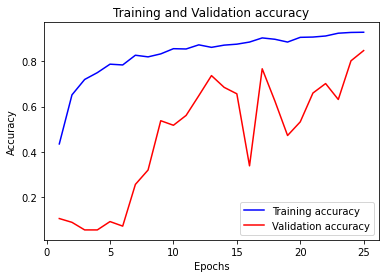

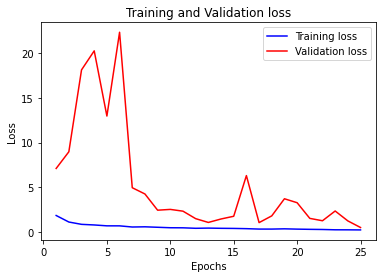

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
#plt.savefig("TrainingAValidationAccuracy.png")

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation loss')
plt.legend()
#plt.savefig("TrainingAValidationLoss.png")
plt.show()

In [ ]:
from PIL import Image
image_dir="custom_dataset/SR_input/HRPlantVillage/Tomato__Tomato_mosaic_virus/res_0020.png"
im1 = Image.open(image_dir)

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [ ]:
result=model.predict(npp_image)
print(result)

1/1 [==============================] - 0s 309ms/step
[[3.0223638e-01 4.7868728e-08 4.5878656e-10 4.0966182e-11 2.2207698e-06
  2.6796793e-10 1.9098161e-05 2.1120028e-11 7.0909499e-07 1.5386206e-03
  2.2871139e-12 1.2786974e-07 9.8610031e-10 6.9620281e-01 3.0379324e-11]]


In [ ]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.6962028
Tomato__Tomato_mosaic_virus
